In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
plt.style.use('default')

from utils.model_measure import print_regression_measure

# 1. Dataset

a regression dataset

In [4]:
from sklearn.datasets import load_diabetes
data_X, data_Y = load_diabetes(return_X_y=True, as_frame=False)


n_samples = len(data_X)

# sample weights
rng = np.random.default_rng(seed=42)
data_weight = rng.normal(loc=0.0, scale=1.0, size=n_samples)
data_weight = np.abs(data_weight) + 1.0

train_idx, test_idx = train_test_split(range(n_samples), test_size=0.3, random_state=0)
train_X, test_X = data_X[train_idx], data_X[test_idx]
train_Y, test_Y = data_Y[train_idx], data_Y[test_idx]
train_weight, test_weight = data_weight[train_idx], data_weight[test_idx]

print('\nShape of dataset:', data_X.shape, data_Y.shape, data_weight.shape,
      '\nShape of training set:', train_X.shape, train_Y.shape, train_weight.shape,
      '\nShape of testing set:', test_X.shape, test_Y.shape, test_weight.shape)


Shape of dataset: (442, 10) (442,) (442,) 
Shape of training set: (309, 10) (309,) (309,) 
Shape of testing set: (133, 10) (133,) (133,)


Text(0.5, 1.0, 'Distribution of target')

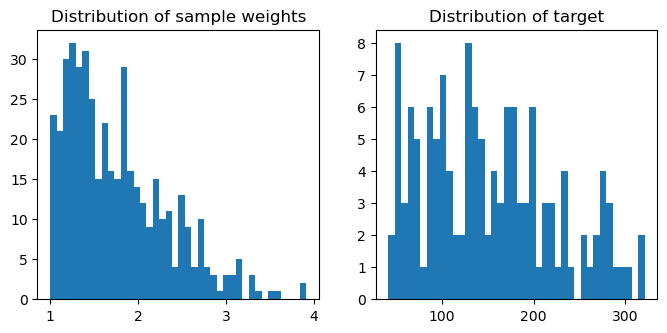

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

ax = axes[0]
ax.hist(data_weight, bins=40)
ax.set_title('Distribution of sample weights')

ax = axes[1]
ax.hist(test_Y, bins=40)
ax.set_title('Distribution of target')

# 2. Weighted bootstrap (bagging)

In [2]:
from sklearn.base import RegressorMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils import check_X_y, _safe_indexing
from sklearn.utils.validation import check_random_state, has_fit_parameter, _check_sample_weight


def _generate_indices(random_state, bootstrap, n_population, n_samples, population_weight=None):
    '''
    original version: scikit-learn/sklearn/ensemble/_bagging.py
    '''
    if not population_weight is not None:
        assert n_population == len(population_weight)
        p = population_weight / np.sum(population_weight)
    else:
        p = None
    
    indices = random_state.choice(a=n_population, size=n_samples, replace=bootstrap, p=p)
    
    return indices
# ============================================================
def _generate_bagging_indices(
    random_state,
    bootstrap_features,
    bootstrap_samples,
    n_features,
    n_samples,
    max_features,
    max_samples,
    sample_weight=None
):  
    '''
    Randomly draw feature and sample indices.
    original version: scikit-learn/sklearn/ensemble/_bagging.py
    '''
    # Get valid random state
    random_state = check_random_state(random_state)

    # Draw indices
    feature_indices = _generate_indices(
        random_state, bootstrap_features, n_features, max_features, sample_weight,
    )
    sample_indices = _generate_indices(
        random_state, bootstrap_samples, n_samples, max_samples
    )

    return feature_indices, sample_indices
# ==========================================================================
def _parallel_build_estimators(
    n_estimators,
    ensemble,
    X,
    y,
    sample_weight,
    seeds,
    total_n_estimators,
    verbose,
    check_input,
    fit_params,
):
    """Private function used to build a batch of estimators within a job."""
    # Retrieve settings
    n_samples, n_features = X.shape
    max_features = ensemble._max_features
    max_samples = ensemble._max_samples
    bootstrap = ensemble.bootstrap
    bootstrap_features = ensemble.bootstrap_features
    has_check_input = has_fit_parameter(ensemble.estimator_, "check_input")
    requires_feature_indexing = bootstrap_features or max_features != n_features

    # Build estimators
    estimators = []
    estimators_features = []

    for i in range(n_estimators):
        if verbose > 1:
            print(
                "Building estimator %d of %d for this parallel run (total %d)..."
                % (i + 1, n_estimators, total_n_estimators)
            )

        random_state = seeds[i]
        estimator = ensemble._make_estimator(append=False, random_state=random_state)
        
        if has_check_input:
            estimator_fit = partial(estimator.fit, check_input=check_input)
        else:
            estimator_fit = estimator.fit

        # Draw random feature, sample indices
        features, indices = _generate_bagging_indices(
            random_state,
            bootstrap_features,
            bootstrap,
            n_features,
            n_samples,
            max_features,
            max_samples,
        )

        fit_params_ = fit_params.copy()

        # TODO(SLEP6): remove if condition for unrouted sample_weight when metadata
        # routing can't be disabled.
        # 1. If routing is enabled, we will check if the routing supports sample
        # weight and use it if it does.
        # 2. If routing is not enabled, we will check if the base
        # estimator supports sample_weight and use it if it does.

        # Note: Row sampling can be achieved either through setting sample_weight or
        # by indexing. The former is more efficient. Therefore, use this method
        # if possible, otherwise use indexing.
        if _routing_enabled():
            request_or_router = get_routing_for_object(ensemble.estimator_)
            consumes_sample_weight = request_or_router.consumes(
                "fit", ("sample_weight",)
            )
        else:
            consumes_sample_weight = support_sample_weight
        if consumes_sample_weight:
            # Draw sub samples, using sample weights, and then fit
            curr_sample_weight = _check_sample_weight(
                fit_params_.pop("sample_weight", None), X
            ).copy()

            if bootstrap:
                sample_counts = np.bincount(indices, minlength=n_samples)
                curr_sample_weight *= sample_counts
            else:
                not_indices_mask = ~indices_to_mask(indices, n_samples)
                curr_sample_weight[not_indices_mask] = 0

            fit_params_["sample_weight"] = curr_sample_weight
            X_ = X[:, features] if requires_feature_indexing else X
            estimator_fit(X_, y, **fit_params_)
        else:
            # cannot use sample_weight, so use indexing
            y_ = _safe_indexing(y, indices)
            X_ = _safe_indexing(X, indices)
            fit_params_ = _check_method_params(X, params=fit_params_, indices=indices)
            if requires_feature_indexing:
                X_ = X_[:, features]
            estimator_fit(X_, y_, **fit_params_)

        estimators.append(estimator)
        estimators_features.append(features)

    return estimators, estimators_features
# ==========================================================================

class WeightedBaggingRegressor(RegressorMixin):
    def __init__(
        self, 
        estimator = None, 
        n_estimators = 10,
        max_samples = 1.0, 
        max_features = 1.0, 
        bootstrap = True, 
        bootstrap_features = False,
        bootstrap_weights = True,
        oob_score = False, 
        n_jobs = None,
        random_state = None, 
        verbose = 0
    ):
        check_estimator(estimator)
        
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.bootstrap_features = bootstrap_features
        self.bootstrap_weights = bootstrap_weights
        self.oob_score = oob_score
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.verbose = verbose
        
    # -----------------------------------------------
    def fit(self, X, y, sample_weight=None):
        X, y = check_X_y(X, y)
        

      

In [ ]:
 
def _generate_indices(random_state, bootstrap, n_population, n_samples):
    """Draw randomly sampled indices."""
    # Draw sample indices
    if bootstrap:
        indices = random_state.randint(0, n_population, n_samples)
    else:
        indices = sample_without_replacement(
            n_population, n_samples, random_state=random_state
        )

    return indices


def _generate_bagging_indices(
    random_state,
    bootstrap_features,
    bootstrap_samples,
    n_features,
    n_samples,
    max_features,
    max_samples,
):
    """Randomly draw feature and sample indices."""
    # Get valid random state
    random_state = check_random_state(random_state)

    # Draw indices
    feature_indices = _generate_indices(
        random_state, bootstrap_features, n_features, max_features
    )
    sample_indices = _generate_indices(
        random_state, bootstrap_samples, n_samples, max_samples
    )

    return feature_indices, sample_indices


def _parallel_build_estimators(
    n_estimators,
    ensemble,
    X,
    y,
    seeds,
    total_n_estimators,
    verbose,
    check_input,
    fit_params,
):
    """Private function used to build a batch of estimators within a job."""
    # Retrieve settings
    n_samples, n_features = X.shape
    max_features = ensemble._max_features
    max_samples = ensemble._max_samples
    bootstrap = ensemble.bootstrap
    bootstrap_features = ensemble.bootstrap_features
    has_check_input = has_fit_parameter(ensemble.estimator_, "check_input")
    requires_feature_indexing = bootstrap_features or max_features != n_features

    # Build estimators
    estimators = []
    estimators_features = []

    # TODO: (slep6) remove if condition for unrouted sample_weight when metadata
    # routing can't be disabled.
    support_sample_weight = has_fit_parameter(ensemble.estimator_, "sample_weight")
    if not _routing_enabled() and (
        not support_sample_weight and fit_params.get("sample_weight") is not None
    ):
        raise ValueError(
            "The base estimator doesn't support sample weight, but sample_weight is "
            "passed to the fit method."
        )

    for i in range(n_estimators):
        if verbose > 1:
            print(
                "Building estimator %d of %d for this parallel run (total %d)..."
                % (i + 1, n_estimators, total_n_estimators)
            )

        random_state = seeds[i]
        estimator = ensemble._make_estimator(append=False, random_state=random_state)

        if has_check_input:
            estimator_fit = partial(estimator.fit, check_input=check_input)
        else:
            estimator_fit = estimator.fit

        # Draw random feature, sample indices
        features, indices = _generate_bagging_indices(
            random_state,
            bootstrap_features,
            bootstrap,
            n_features,
            n_samples,
            max_features,
            max_samples,
        )

        fit_params_ = fit_params.copy()

        # TODO(SLEP6): remove if condition for unrouted sample_weight when metadata
        # routing can't be disabled.
        # 1. If routing is enabled, we will check if the routing supports sample
        # weight and use it if it does.
        # 2. If routing is not enabled, we will check if the base
        # estimator supports sample_weight and use it if it does.

        # Note: Row sampling can be achieved either through setting sample_weight or
        # by indexing. The former is more efficient. Therefore, use this method
        # if possible, otherwise use indexing.
        if _routing_enabled():
            request_or_router = get_routing_for_object(ensemble.estimator_)
            consumes_sample_weight = request_or_router.consumes(
                "fit", ("sample_weight",)
            )
        else:
            consumes_sample_weight = support_sample_weight
        if consumes_sample_weight:
            # Draw sub samples, using sample weights, and then fit
            curr_sample_weight = _check_sample_weight(
                fit_params_.pop("sample_weight", None), X
            ).copy()

            if bootstrap:
                sample_counts = np.bincount(indices, minlength=n_samples)
                curr_sample_weight *= sample_counts
            else:
                not_indices_mask = ~indices_to_mask(indices, n_samples)
                curr_sample_weight[not_indices_mask] = 0

            fit_params_["sample_weight"] = curr_sample_weight
            X_ = X[:, features] if requires_feature_indexing else X
            estimator_fit(X_, y, **fit_params_)
        else:
            # cannot use sample_weight, so use indexing
            y_ = _safe_indexing(y, indices)
            X_ = _safe_indexing(X, indices)
            fit_params_ = _check_method_params(X, params=fit_params_, indices=indices)
            if requires_feature_indexing:
                X_ = X_[:, features]
            estimator_fit(X_, y_, **fit_params_)

        estimators.append(estimator)
        estimators_features.append(features)

    return estimators, estimators_features